In [ ]:
!pip install rasterio
!pip install geopandas
!pip install seaborn

import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-5-ab384dddb212>:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-5-ab384dddb212>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


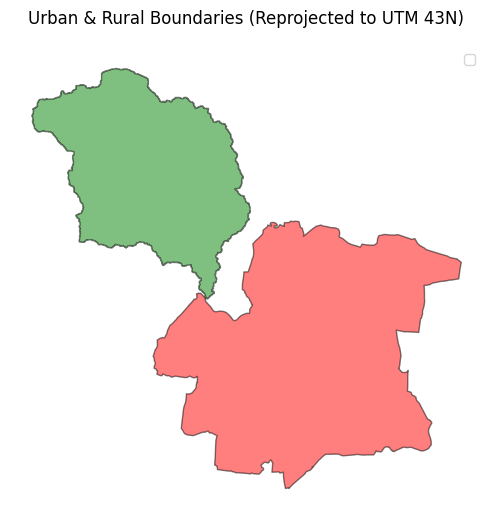

In [ ]:
# Load shapefiles
urban_shapefile = gpd.read_file("/content/drive/MyDrive/Python project pkg/NMCf.shp")
rural_shapefile = gpd.read_file("/content/drive/MyDrive/Python project pkg/ALANDI WATERSHED.shp")

# Define target CRS (UTM Zone 43N)
target_crs = "EPSG:32643"

# Set the CRS of the shapefiles if they are not defined
# This assumes your shapefiles are in EPSG:4326 (WGS 84)
# If they have a different original CRS, replace 4326 with the correct EPSG code
if urban_shapefile.crs is None:
    urban_shapefile = urban_shapefile.set_crs(epsg=4326)
if rural_shapefile.crs is None:
    rural_shapefile = rural_shapefile.set_crs(epsg=4326)


# Reproject shapefiles to the target CRS
urban_shapefile = urban_shapefile.to_crs(target_crs)
rural_shapefile = rural_shapefile.to_crs(target_crs)

# Plot the reprojected shapefiles
fig, ax = plt.subplots(figsize=(8, 6))
urban_shapefile.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, label="Urban")
rural_shapefile.plot(ax=ax, color="green", edgecolor="black", alpha=0.5, label="Rural")
plt.title("Urban & Rural Boundaries (Reprojected to UTM 43N)")
plt.axis("off")
plt.legend()

plt.show()


In [ ]:
def reproject_raster(input_raster, target_crs):
    """Reprojects raster to a common CRS."""
    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        # Create new raster metadata
        kwargs = src.meta.copy()
        kwargs.update({"crs": target_crs, "transform": transform, "width": width, "height": height})

        output_raster = input_raster.replace(".TIF", "_reprojected.TIF")

        # Reproject and save new raster
        with rasterio.open(output_raster, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest,
                )
        return output_raster


In [ ]:
# Define Landsat band file paths
bands = {
    "NIR": "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B5.TIF",
    "SWIR": "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B6.TIF",
    "RED": "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B4.TIF",
    "GREEN": "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B3.TIF",
    "THERMAL": "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_ST_B10.TIF",
}

# Reproject all raster bands
reprojected_bands = {key: reproject_raster(path, target_crs) for key, path in bands.items()}


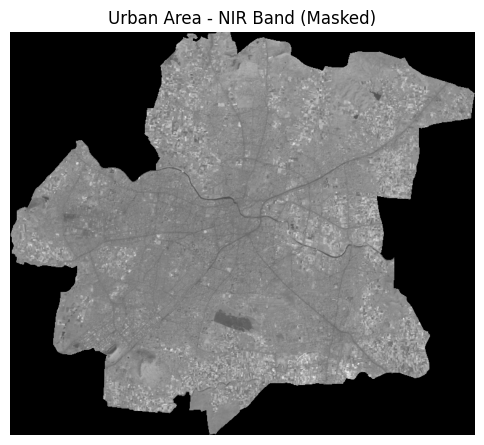

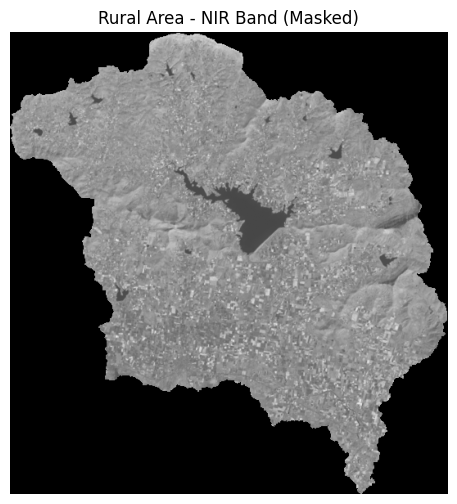

In [ ]:
def mask_raster(raster_path, shapefile):
    """Masks raster using a shapefile."""
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
        return out_image[0]  # Extract masked array

# Mask the reprojected rasters
masked_data = {
    key: {
        "urban": mask_raster(reprojected_bands[key], urban_shapefile),
        "rural": mask_raster(reprojected_bands[key], rural_shapefile),
    }
    for key in reprojected_bands
}

# Display an example masked raster (Urban NIR)
plt.figure(figsize=(6, 6))
plt.imshow(masked_data["NIR"]["urban"], cmap="gray")
plt.title("Urban Area - NIR Band (Masked)")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(masked_data["NIR"]["rural"], cmap="gray")
plt.title("Rural Area - NIR Band (Masked)")
plt.axis("off")
plt.show()

In [ ]:
def safe_divide(a, b):
    """Avoids division by zero."""
    return np.where((a + b) == 0, np.nan, (a - b) / (a + b))

# Compute indices for urban & rural areas
urban_ndbi = safe_divide(masked_data["SWIR"]["urban"], masked_data["NIR"]["urban"])
rural_ndbi = safe_divide(masked_data["SWIR"]["rural"], masked_data["NIR"]["rural"])

urban_ndvi = safe_divide(masked_data["NIR"]["urban"], masked_data["RED"]["urban"])
rural_ndvi = safe_divide(masked_data["NIR"]["rural"], masked_data["RED"]["rural"])

urban_mndwi = safe_divide(masked_data["GREEN"]["urban"], masked_data["SWIR"]["urban"])
rural_mndwi = safe_divide(masked_data["GREEN"]["rural"], masked_data["SWIR"]["rural"])


<ipython-input-39-5a8f302deba5>:3: RuntimeWarning: invalid value encountered in divide
  return np.where((a + b) == 0, np.nan, (a - b) / (a + b))


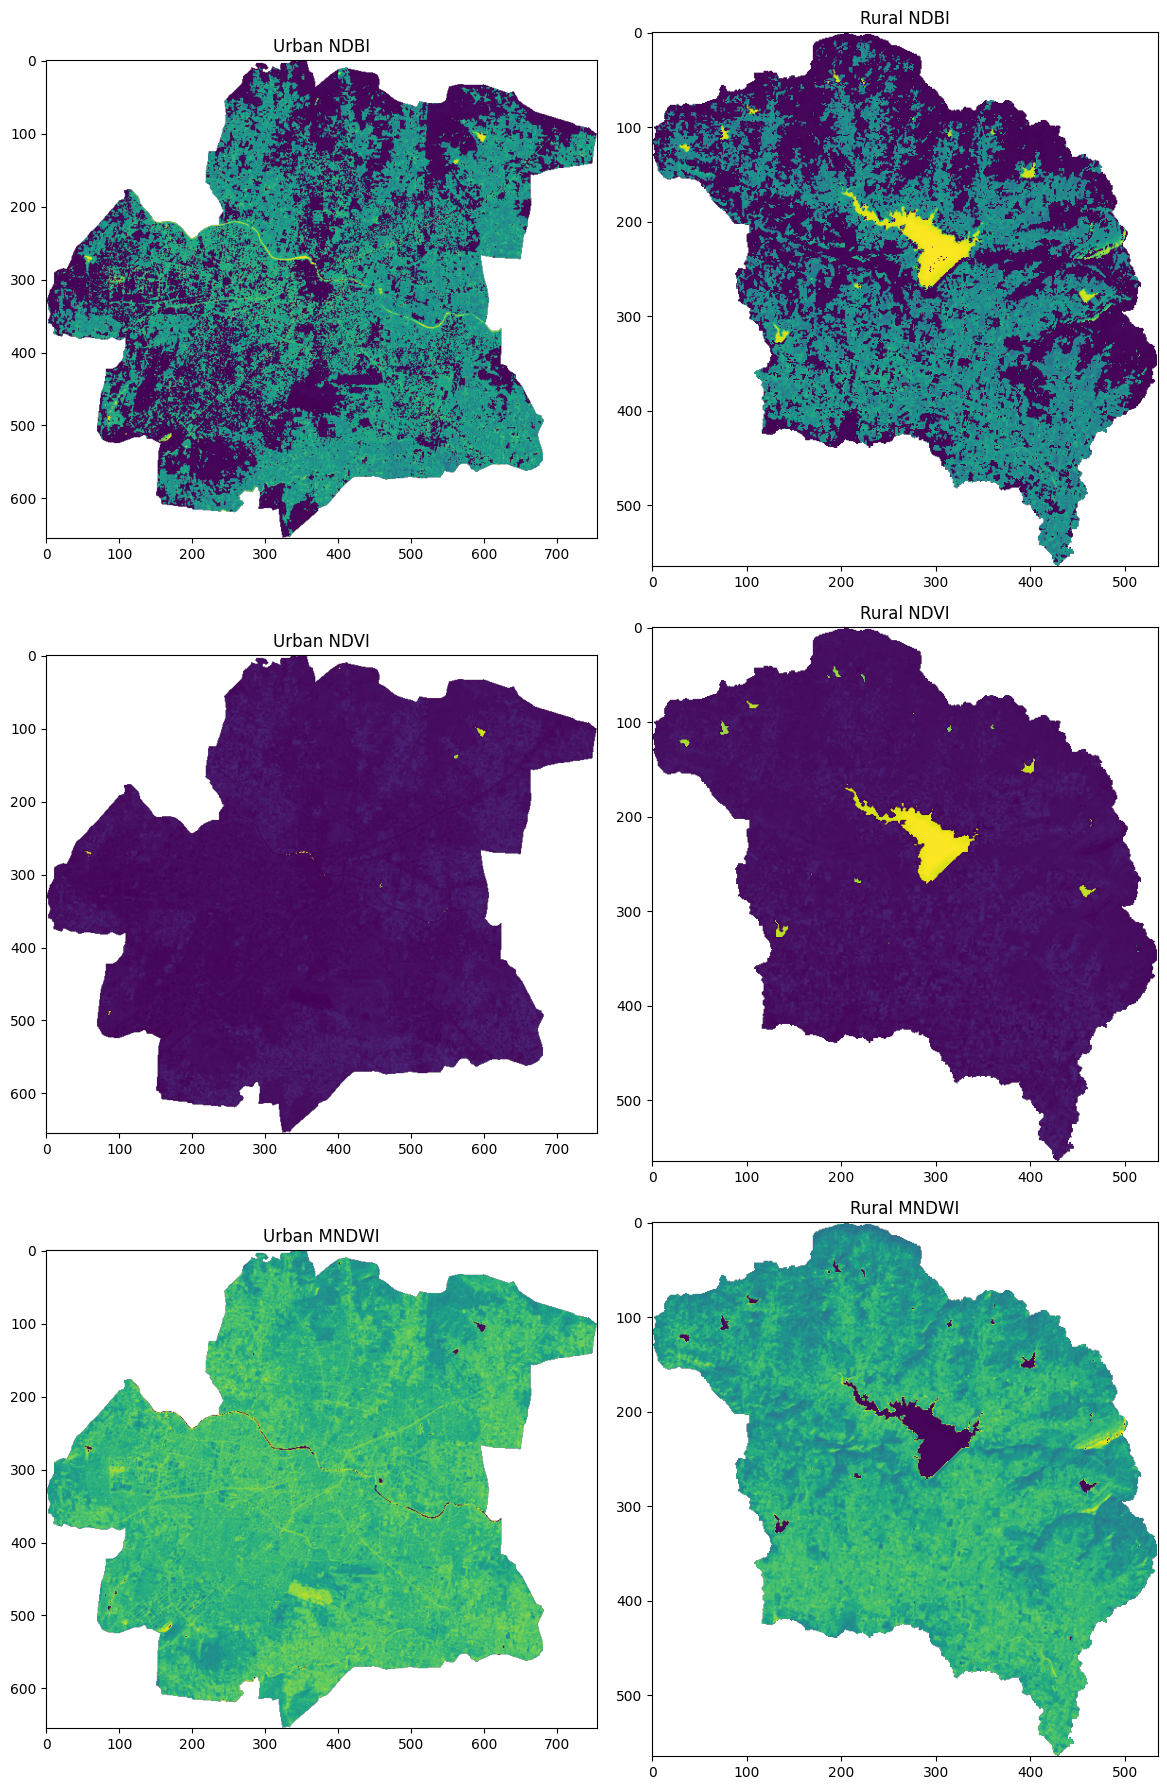

In [ ]:
# prompt: show me all indices which are calculated above  ndbi ,ndvi mndwi means plot oit

import matplotlib.pyplot as plt

# Assuming urban_ndbi, rural_ndbi, urban_ndvi, rural_ndvi, urban_mndwi, and rural_mndwi are defined

# Create a figure and axes for the plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Function to plot indices
def plot_indices(ax, data, title, cmap='viridis'):
    im = ax.imshow(data, cmap=cmap)
    ax.set_title(title)
    plt.axis()


# Plot the indices
plot_indices(axes[0, 0], urban_ndbi, 'Urban NDBI')
plot_indices(axes[0, 1], rural_ndbi, 'Rural NDBI')

plot_indices(axes[1, 0], urban_ndvi, 'Urban NDVI')
plot_indices(axes[1, 1], rural_ndvi, 'Rural NDVI')

plot_indices(axes[2, 0], urban_mndwi, 'Urban MNDWI')
plot_indices(axes[2, 1], rural_mndwi, 'Rural MNDWI')

plt.tight_layout()
plt.show()


<ipython-input-38-11ac1e091d36>:29: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


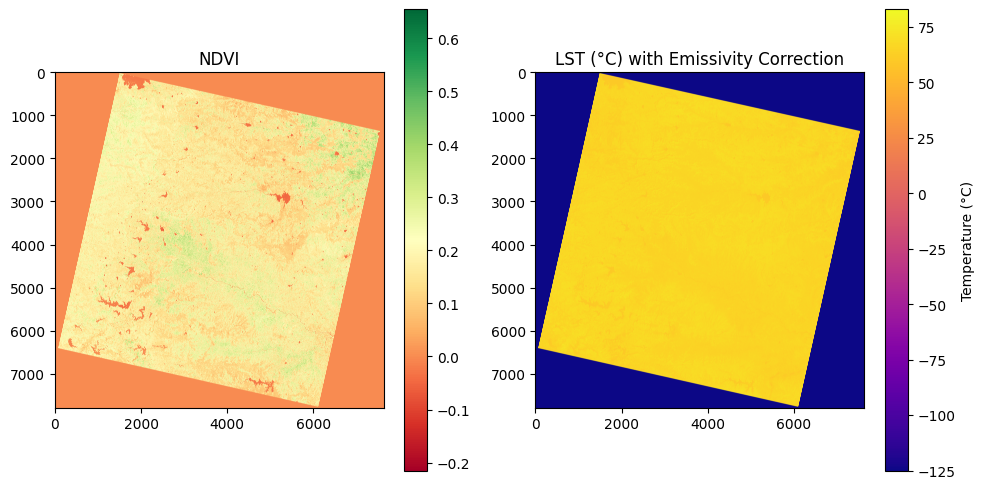

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# === Constants from MTL.txt ===
RADIANCE_MULT_B10 = 3.3420e-04
RADIANCE_ADD_B10 = 0.10000
K1_CONSTANT_B10 = 774.8853
K2_CONSTANT_B10 = 1321.0789
WAVELENGTH = 10.8  # µm for Band 10
PLANCK_CONST = 14388  # Constant used in LST emissivity correction

# === Step 1: Load B4 (Red), B5 (NIR), and B10 (Thermal) ===
b4_path = "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B4.TIF"
b5_path = "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_SR_B5.TIF"
b10_path = "/content/drive/MyDrive/Python project pkg/LC08_L2SP_147046_20250129_20250131_02_T1_ST_B10.TIF"

with rasterio.open(b4_path) as red_src:
    red = red_src.read(1).astype('float32')
    profile = red_src.profile

with rasterio.open(b5_path) as nir_src:
    nir = nir_src.read(1).astype('float32')

with rasterio.open(b10_path) as b10_src:
    b10 = b10_src.read(1).astype('float32')

# === Step 2: Compute NDVI ===
ndvi = (nir - red) / (nir + red)
ndvi = np.where((nir + red) == 0, 0, ndvi)  # Avoid division by zero

# === Step 3: Estimate Land Surface Emissivity (LSE) from NDVI ===
# According to NDVI thresholds (Sobrino et al., 2004)
emissivity = np.where(
    ndvi < 0.2, 0.975,
    np.where(ndvi > 0.5, 0.990,
             0.970 + 0.0033 * ((ndvi - 0.2) * 10)))  # Linear scaling

# === Step 4: Radiance from Band 10 ===
radiance = RADIANCE_MULT_B10 * b10 + RADIANCE_ADD_B10

# === Step 5: Brightness Temperature (Kelvin) ===
bt = K2_CONSTANT_B10 / (np.log((K1_CONSTANT_B10 / radiance) + 1))

# === Step 6: LST with Emissivity Correction (°C) ===
lst_kelvin = bt / (1 + (WAVELENGTH * bt / PLANCK_CONST) * np.log(emissivity))
lst_celsius = lst_kelvin - 273.15



# === Step 8: Plot NDVI and LST ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title("NDVI")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(lst_celsius, cmap='plasma')
plt.title("LST (°C) with Emissivity Correction")
plt.colorbar(label="Temperature (°C)")
plt.tight_layout()
plt.show()


In [ ]:


# Clip the LST raster using the urban and rural shapefiles
def clip_raster(raster_path, shapefile, output_path):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

lst_celsius_path = "/content/LST_Celsius_EmissivityCorrected.TIF"

clip_raster(lst_celsius_path, urban_shapefile, "lst_urban_clip.tif")
clip_raster(lst_celsius_path, rural_shapefile, "lst_rural_clip.tif")


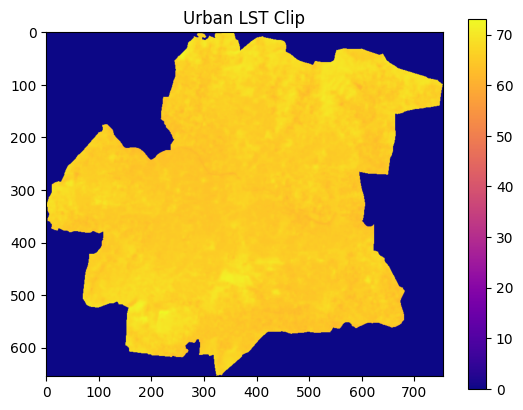

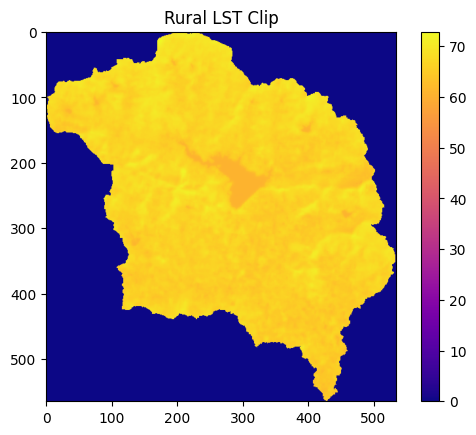

In [ ]:
# Display the clipped rasters
with rasterio.open("/content/lst_urban_clip.tif") as src:
    urban_lst = src.read(1)
    plt.imshow(urban_lst, cmap='plasma')
    plt.title("Urban LST Clip")
    plt.colorbar()
    plt.show()

with rasterio.open("/content/lst_rural_clip.tif") as src:
    rural_lst = src.read(1)
    plt.imshow(rural_lst, cmap='plasma')
    plt.title("Rural LST Clip")
    plt.colorbar()
    plt.show()


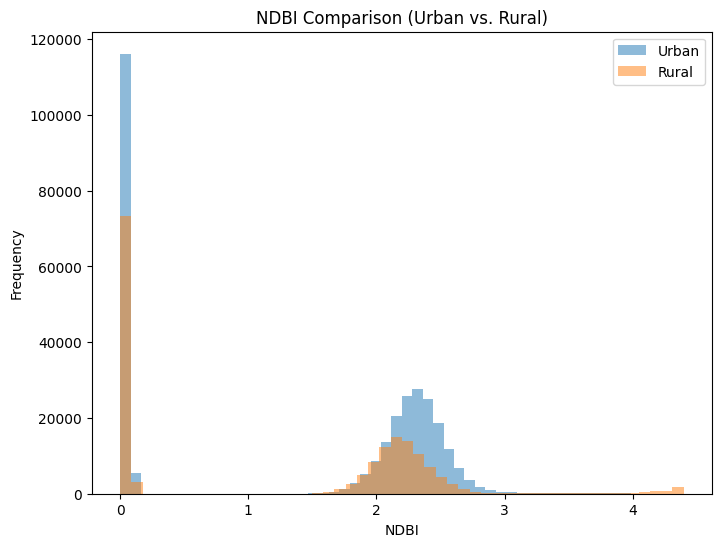

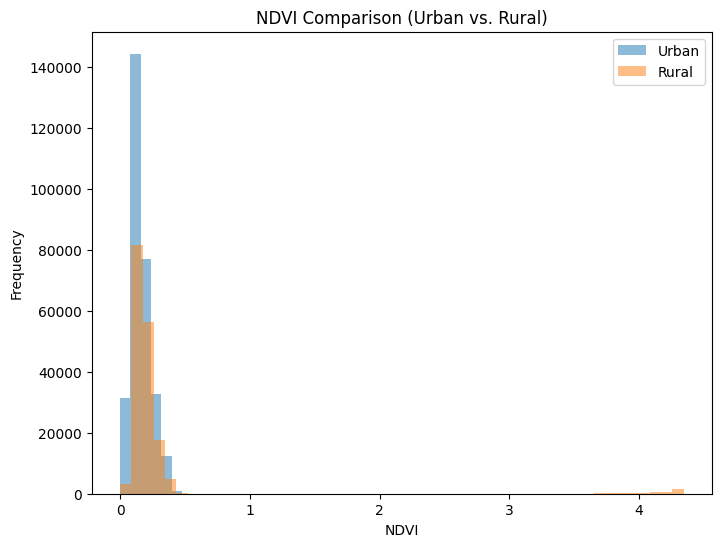

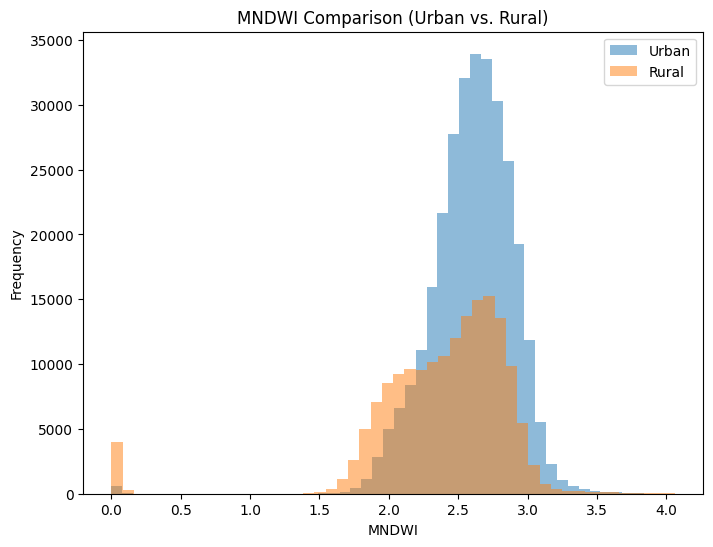

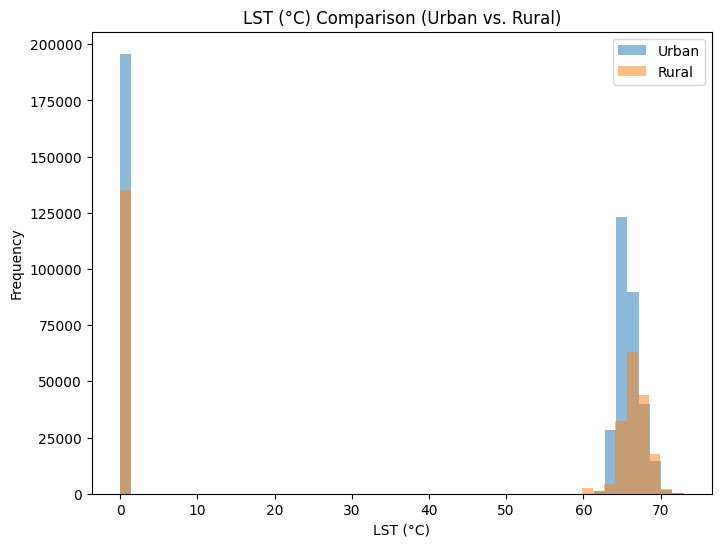

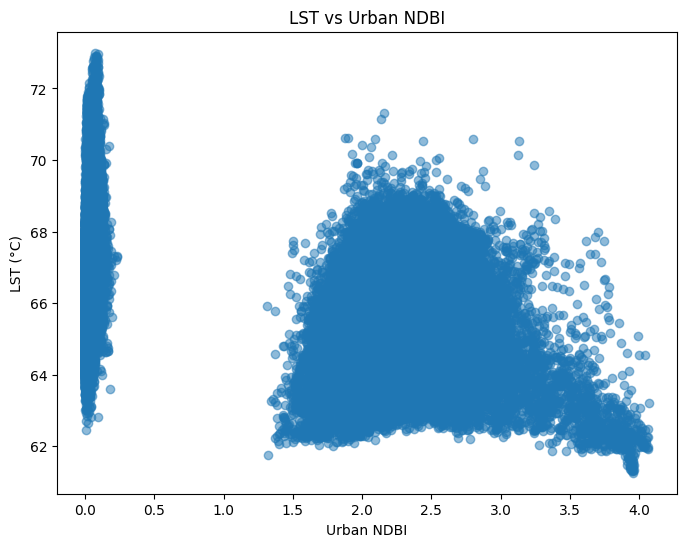

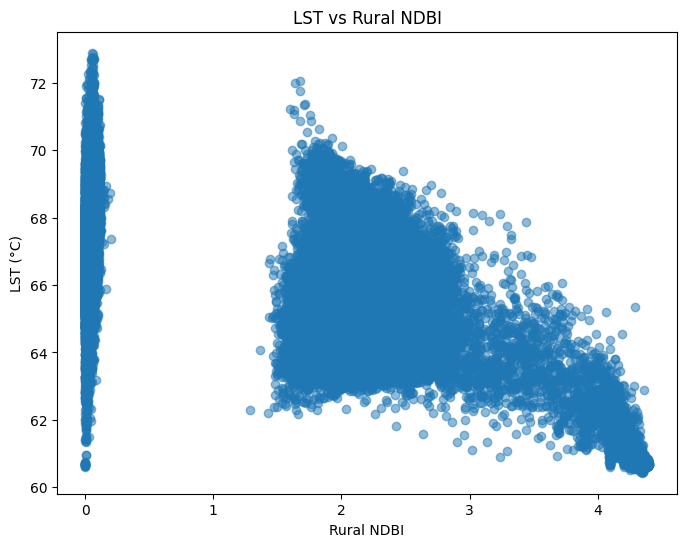

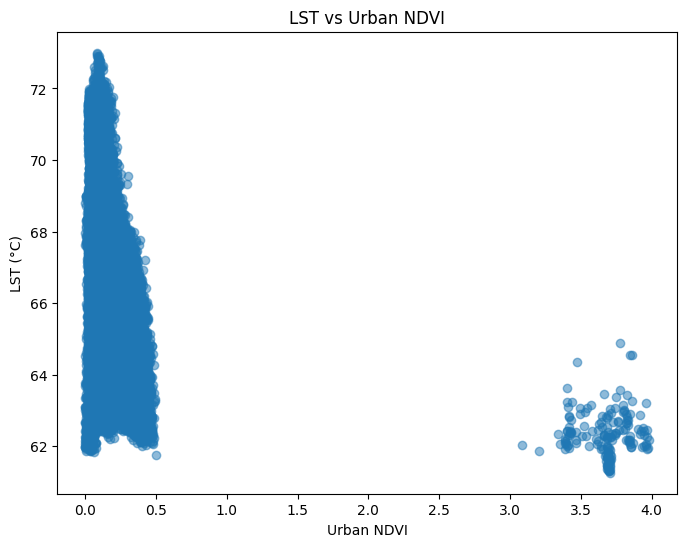

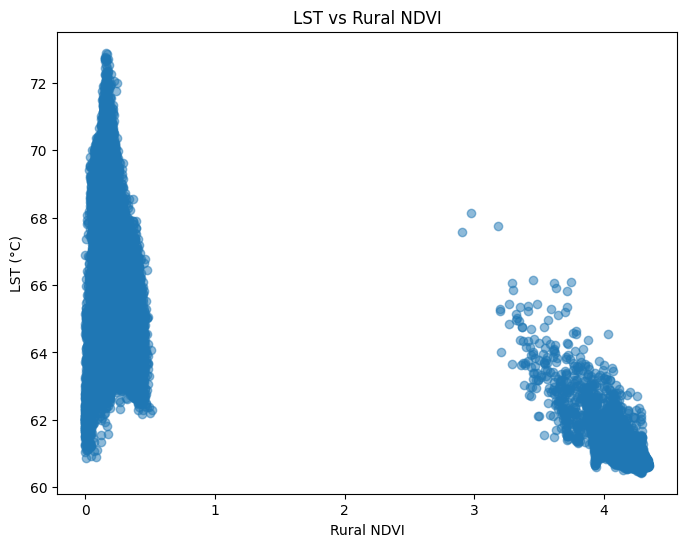

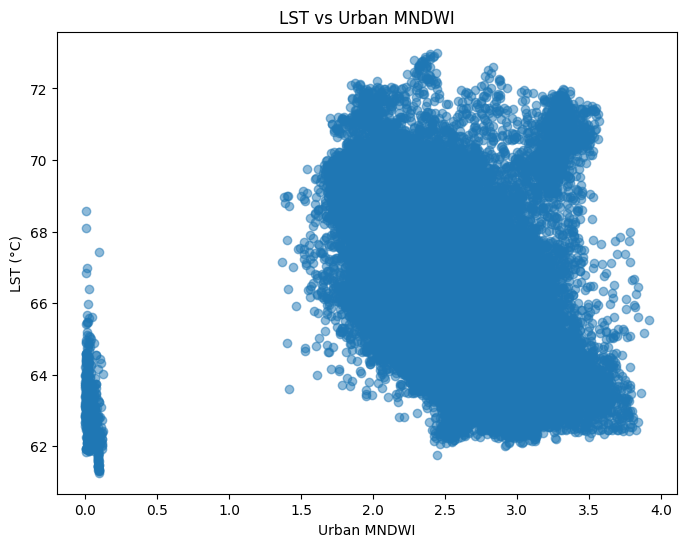

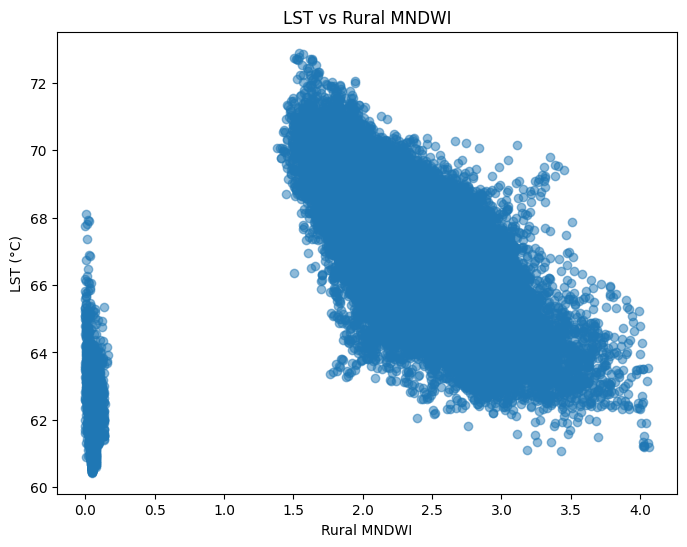

In [ ]:
# prompt: give me more understandable visulaization as compare to above and it shouls be simple

import matplotlib.pyplot as plt

# Assuming urban_lst, rural_lst, urban_ndbi, rural_ndbi, urban_ndvi, rural_ndvi, urban_mndwi, and rural_mndwi are defined

# Function to create comparison plots
def plot_comparison(urban_data, rural_data, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.hist(urban_data.flatten(), bins=50, alpha=0.5, label='Urban')
    plt.hist(rural_data.flatten(), bins=50, alpha=0.5, label='Rural')
    plt.xlabel(title)
    plt.ylabel(ylabel)
    plt.title(f'{title} Comparison (Urban vs. Rural)')
    plt.legend()
    plt.show()

# Plot comparisons for all indices
plot_comparison(urban_ndbi, rural_ndbi, 'NDBI', 'Frequency')
plot_comparison(urban_ndvi, rural_ndvi, 'NDVI', 'Frequency')
plot_comparison(urban_mndwi, rural_mndwi, 'MNDWI', 'Frequency')

# Plot LST comparison
plot_comparison(urban_lst, rural_lst, 'LST (°C)', 'Frequency')


# Scatter Plot of LST vs. Indices
def scatter_plot_lst_vs_index(lst_data, index_data, title):
    plt.figure(figsize=(8,6))
    plt.scatter(index_data.flatten(), lst_data.flatten(), alpha=0.5)
    plt.xlabel(title)
    plt.ylabel("LST (°C)")
    plt.title(f"LST vs {title}")
    plt.show()

scatter_plot_lst_vs_index(urban_lst, urban_ndbi, 'Urban NDBI')
scatter_plot_lst_vs_index(rural_lst, rural_ndbi, 'Rural NDBI')
scatter_plot_lst_vs_index(urban_lst, urban_ndvi, 'Urban NDVI')
scatter_plot_lst_vs_index(rural_lst, rural_ndvi, 'Rural NDVI')
scatter_plot_lst_vs_index(urban_lst, urban_mndwi, 'Urban MNDWI')
scatter_plot_lst_vs_index(rural_lst, rural_mndwi, 'Rural MNDWI')
